In [2]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
from gmm import GMM

In [418]:
import scipy.stats as st

class GMM:
    def __init__(self, k):
        self.k = k
        self.means = []
        self.covariances = []
        self.pis = []
        self.gammas = []

    def fit(self, data):
        """
        :params data: np.array of shape (..., dim)
                                  where dim is number of dimensions of point
        """
        
#         data = self._normalize(np.array(data, np.float), True)
        data = np.array(data, np.float)
#         print(data)
        
        self._initialize_params(data)
        for i in range(100):  # TODO: fix
            self._E_step(data)

#             print(self.means)
#             print(self.covariances)
#             print(self.pis)
#             print(self.gammas)
#             print("--------------------")
            self._M_step(data)
            
#             print(self.means)
#             print(self.covariances)
#             print(self.pis)
#             print(self.gammas)
            
#             break

#     def _normalize(self, data, training):
#         if training:
#             self.norm_coef = (data.max(axis=0) - data.min(axis=0))[None]
#         return data/self.norm_coef
        
    def _initialize_params(self, data):
        self.pis = np.ones(self.k, np.float)/self.k
        self.means = data[np.random.choice(data.shape[0], self.k)]
        self.covariances = np.array([np.identity(data.shape[-1])] * self.k) 

    def _E_step(self, data):
        normalpdfs = [st.multivariate_normal(self.means[i], self.covariances[i]).pdf
                      for i in range(self.k)]
        self.gammas = np.zeros((data.shape[0], self.k), np.float)
        for i in range(data.shape[0]):
#             print(np.array([pdf(data[i]) for pdf in normalpdfs]))
#             print([normalpdfs[i](self.means[i]) for i in range(len(normalpdfs))])
            
            self.gammas[i] = self.pis * np.array([pdf(data[i]) for pdf in normalpdfs])
#             print(self.gammas[i])
            self.gammas[i] /= self.gammas[i].sum()

    def _M_step(self, data):
        gammaSums = self.gammas.sum(axis=0)[None].T
        self.means = self.gammas.T.dot(data) /gammaSums
        
        self.covariances = np.zeros_like(self.covariances)
        for j in range(self.k):
            for i in range(data.shape[0]):
                a = (data[i] - self.means[j])[None]
#                 print(a.shape)
                self.covariances[j] += self.gammas[i,j] * (a.T.dot(a))
        
        
#         self.covariances = np.array([np.sum([self.gammas[i,j]*(data[i] - self.means[j])[None].T.dot(
#             (data[i] - self.means[j])[None]) for i in range(data.shape[0])]) for j in range(self.k)])/gammaSums
        self.pis = (gammaSums/data.shape[0]).T[0]
        
    def predict(self, data):
        """
        :param data: np.array of shape (..., dim)
        :return: np.array of shape (...) without dims
                         each element is integer from 0 to k-1
        """
        data = self._normalize(data, False)

        normalpdfs = [st.multivariate_normal(self.means[i], self.covariances[i]).pdf
                      for i in range(self.k)]
        return np.array([self._pred(d) for d in data])

    def _pred(self, x, normalpdfs):
        return np.argmax([pdf(x) for pdf in normalpdfs])
        
        
    def get_means(self):
        return self.means.copy() #* self.norm_coef

    def get_covariances(self):
        return self.covariances.copy()

    def get_pis(self):
        return self.pis.copy()

In [419]:
x=np.array([1,2,3])

In [420]:
x[None].T.dot(x[None])

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [421]:
x=np.linspace(-10,10,100)
n = st.multivariate_normal((1,2),[[1,1],[0,1]])
print(n.pdf((1,2)))

0.15915494309189535


In [422]:
a=np.array([[1,2],[2,3],[2,3],[2,3],[2,3],[2,3],[2,3],[2,3],[2,3],[2,3],[2,3],[2,3]])
m=np.array([[2,3],[3,4]])
a.sum(axis=0)

array([23, 35])

In [423]:
def get_ellipse_from_covariance(matrix, std_multiplier=2):
    values, vectors = np.linalg.eig(matrix)
    maxI = np.argmax(values)
    large, small = values[maxI], values[1 - maxI]
    return (std_multiplier * np.sqrt(large),
            std_multiplier * np.sqrt(small),
            np.rad2deg(np.arccos(vectors[0, 0])))

In [426]:
def run_gmm(dataPath, name, k):
    df = pd.read_csv(dataPath)
    global data
    data = np.array(df[['X', 'Y']], np.float)[:1000]/100000
    plt.clf()
    plt.scatter(data[:, 0], data[:, 1], s=3, color='blue')

    global gmm

    gmm = GMM(k)
    gmm.fit(data)
    mean = gmm.get_means()
    sigma = gmm.get_covariances()
    pi = gmm.get_pis()

    # Plot ellipses for each of covariance matrices.
    for k in range(len(sigma)):
#         print(sigma[k])
        h, w, angle = get_ellipse_from_covariance(sigma[k])
        e = patches.Ellipse(mean[k], w, h, angle=angle)
        e.set_alpha(np.power(pi[k], .3))
        e.set_facecolor('red')
        plt.axes().add_artist(e)
    plt.savefig('covariances_{}_{}'.format(dataPath, name).replace('.','_'))
    plt.show()

/home/hov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


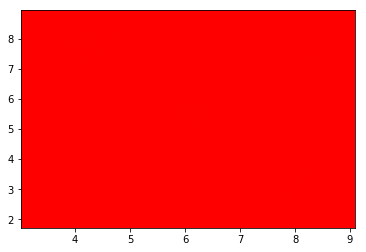

In [427]:
run_gmm("sparse_clusters.csv", "hov", 15)

In [417]:
gmm.gammas.shape

(100, 15)

In [399]:
gmm.pis

array([[0.06198979],
       [0.07026803],
       [0.06730529],
       [0.07027997],
       [0.07006088],
       [0.06952491],
       [0.06418081],
       [0.06256024],
       [0.06970543],
       [0.06460767],
       [0.066656  ],
       [0.05675416],
       [0.07022885],
       [0.06617254],
       [0.06970543]])

In [400]:
st.multivariate_normal(gmm.means[1], gmm.covariances[1]).pdf(data[1])

0.19221730216322505